# Rede neural 65622 - Adaptações dos parâmetros
Melhor desempenho considerando o critério de maior cos_sim e menor loss 

In [1]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)

D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers

        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0])])
        for i in range(0, self.num_layers-2):
            self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1])])              
        self.linears.append(nn.Linear(layers_size[-1], output_size))

#     def forward(self, x):
#         for layer in self.linears[0:-1]:                   
#             x = torch.tanh(layer(x))
#         x = self.linears[-1](x)
#         return(x)

# Aplicando função de ativação na última camada tbm
### Tentar mudar pra sigmoide se deixar a normalização de 0,1
    def forward(self, x):
        for layer in self.linears:                   
            x = torch.tanh(layer(x))
        return(x)

In [3]:
testes = pd.read_csv("Loop_Testes_Regressao2.csv")
rede = testes.iloc[np.where(testes["index"]==65622)]
rede

,index,net_param,ncamadas,n_features,features_col,features_name,random_state,data_train,data_train_resample,test_loss,test_cos_sim,net
15622,65622.0,<bound method Module.parameters of Net(\r\n (...,6,18,[ 1 15 41 49 52 58 86 89 94 97 99 1...,"['AgeGroup', 'Analgesic', 'Diabetesmellitus', ...",77,124,280,0.04118,0.873746,net_65622


In [4]:
print(rede.iloc[0,1])

<bound method Module.parameters of Net(
  (linears): ModuleList(
    (0): Linear(in_features=18, out_features=12, bias=True)
    (1): Linear(in_features=12, out_features=9, bias=True)
    (2): Linear(in_features=9, out_features=6, bias=True)
    (3): Linear(in_features=6, out_features=3, bias=True)
    (4): Linear(in_features=3, out_features=1, bias=True)
    (5): Linear(in_features=1, out_features=1, bias=True)
  )
)>


Numero de features: 18
Colunas:  [0, 15, 41, 49, 52, 58, 86, 89, 94, 97, 99, 111, 117, 123, 135, 152, 167, 173]
Features:  ['Age', 'Analgesic', 'Diabetesmellitus', 'Hblocker', 'Hypercholesterolemia', 'Meglitinide', 'Epilepsy', 'Fatty liver', 'Hiatus hernia', 'Inflammation of the tibial nerve', 'Kidney failure', 'Sickle cell anemia', 'Varicose veins of the legs', 'Depression', 'Vasovagal syncope', 'Hypothyroidism_total', 'Internal fixation in the leg', 'PaceMaker']
Random State: 77
Histogramas dos dados de treino


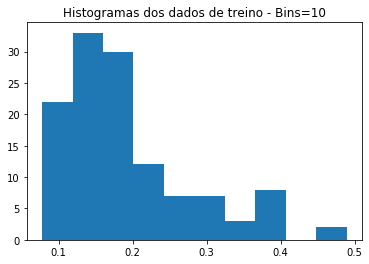

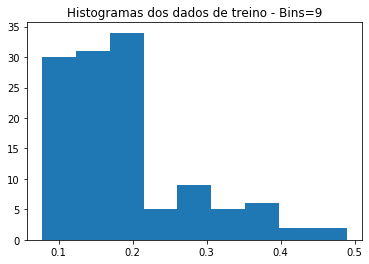

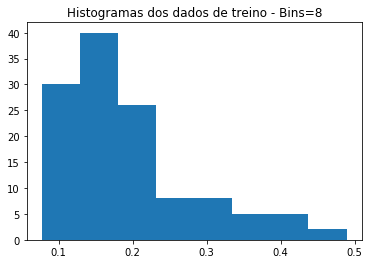

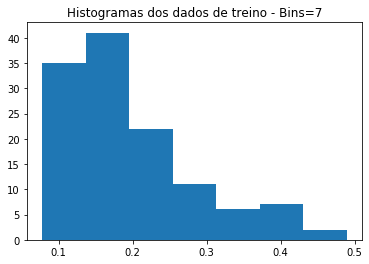

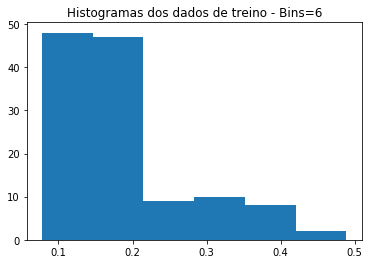

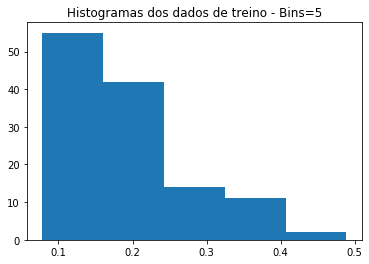

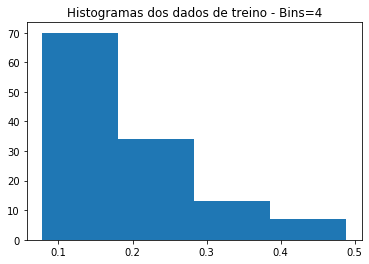

Data train: 124
Data train resample: 280
Histograma dos dados de treino com Resample SMOTE


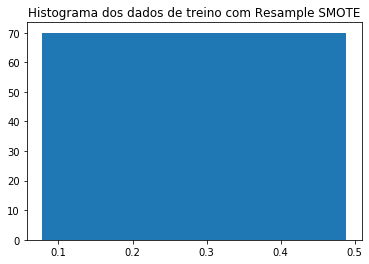

Number of layers: 6
Inicial size layer: 12
Layers sizes: [12, 9, 6, 3, 1]


In [5]:
data = pd.read_pickle("data_closed_rigid_o")
pf50 = data["PF50_closed_rigid"].values

# Sorteando quais caracteristicas usar
n_features = rede.iloc[0,3]
print('Numero de features: %d' % (n_features))
# Troca de AgeGroup(1) por Age(0)
columns =   [0, 15, 41, 49, 52, 58, 86, 89, 94, 97, 99, 111, 117, 123, 135, 152, 167, 173]
print('Colunas: ',columns)

features = data.iloc[:,columns]
features_names = features.columns
print('Features: ',list(features_names))
X = features.values
y = pf50.reshape(len(pf50), 1)

# Separando o dataset em treino e teste e validação (treino 60, teste 30, validação 10)
random_state = rede.iloc[0,6]
print('Random State: %d' % (random_state))
X_train, X_test_vali, y_train, y_test_vali = train_test_split(X, y, test_size=0.4, random_state=random_state)
X_vali, X_test, y_vali, y_test = train_test_split(X_test_vali, y_test_vali, test_size=0.75, random_state=random_state)

# Histograma dos dados de treino
print("Histogramas dos dados de treino")
for nbins in range(10,1,-1):
    n, bins, patches = plt.hist(y_train, nbins)
    plt.title("Histogramas dos dados de treino - Bins="+str(nbins))
    plt.show()
    if np.min(n)>3:
        break
        
# Indica qual o bin correspondente para cada dado
indices = np.digitize(y_train, bins)

# Arrumando o caso do último valor que não é incluído no último bin
indices[indices>nbins]=nbins
indices = indices.reshape(len(indices),)

# SMOTE - Data Augmentation
data_train = np.hstack([X_train, y_train])
print('Data train: %d' % (data_train.shape[0]))
sm = SMOTE(k_neighbors=np.int(n.min()-1), random_state=42)
data_train_res, indices_res = sm.fit_resample(data_train, indices)
print('Data train resample: %d' % (data_train_res.shape[0]))

# Histograma dos dados de treino resample
print("Histograma dos dados de treino com Resample SMOTE")
n_res, bins_res, patches_res = plt.hist(data_train_res[:,-1], nbins)
plt.title("Histograma dos dados de treino com Resample SMOTE")
plt.show()

# Declarando o dado resample como dado de treino
X_train = data_train_res[:,0:-1]
y_train = data_train_res[:,-1].reshape(data_train_res.shape[0],1)

# Ajustando o escalamento ao dado de TREINAMENTO (fit) e transformando o dado de treinamento
## Normalização de -1 a 1 --> parece que piorou
scaler_x = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler_x.fit_transform(X_train)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train)

# Transformando o dado de validação
X_vali_scaled = scaler_x.fit_transform(X_vali)
y_vali_scaled = scaler_y.fit_transform(y_vali)

torch.manual_seed(1234)

num_layers = rede.iloc[0,2]
print('Number of layers: %d' % (num_layers))
layer_init_size = 12
print('Inicial size layer: %d' % (layer_init_size))
layers_size = np.linspace(layer_init_size, 1, num_layers-1, dtype=int)
print('Layers sizes:', list(layers_size))

net = Net(input_size=X.shape[1], num_layers=num_layers, layers_size=layers_size , output_size=1)


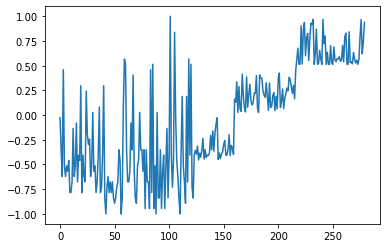

In [6]:
plt.figure()
plt.plot(y_train_scaled)
plt.show()

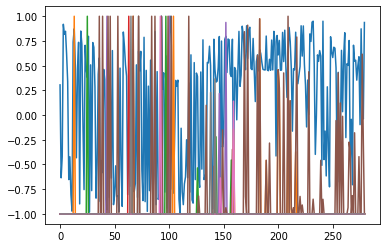

In [7]:
plt.figure()
plt.plot(X_train_scaled)
plt.show()

## Teste com livelossplot

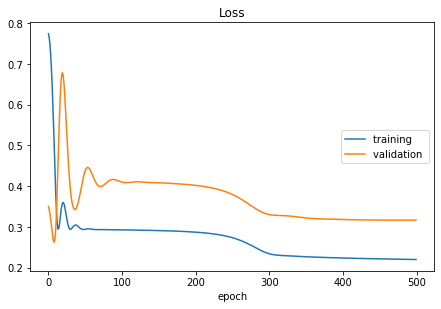

Loss
	training         	 (min:    0.220, max:    0.774, cur:    0.220)
	validation       	 (min:    0.263, max:    0.678, cur:    0.317)


In [8]:
from livelossplot import PlotLosses
# https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb

# Choose optmizer and loss function
criterion = nn.MSELoss()

# Diminuição do lr = learning rate de 0.05 para 0.01
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

# Treinamento utilizando o dado de treino transformado
# Aumento do número de epochs de 5000 para 100000
epochs = 500
loss_train = np.zeros(epochs)
loss_vali = np.zeros(epochs)

liveloss = PlotLosses()

for epoch in range(epochs):
    logs = {}
    
    for phase in ['train', 'validation']:
        if phase == 'train':
            inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
            targets = torch.autograd.Variable(torch.Tensor(y_train_scaled.astype(np.float32)).float())

            optimizer.zero_grad()
            out = net(inputs)
            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()
            loss_train[epoch] = loss.item()
            
#             prefix = 'train_'
            
        else:
            # Incluir validação, sem optimizer, loss backward etc
            ### Comparar valores de loss e gravar a melhor rede com o menor loss
            ### Pode tentar incluir um critério de parada se depois de 1000 epochs não gravar nenhuma rede
            ### Procurar interface gráfica simultânea para plotar loss de treino e validação

            inputs_vali = torch.autograd.Variable(torch.Tensor(X_vali_scaled.astype(np.float32)).float())
            targets_vali = torch.autograd.Variable(torch.Tensor(y_vali_scaled.astype(np.float32)).float())
            out_vali = net(inputs_vali)
            loss_v = criterion(out_vali, targets_vali)
            loss_vali[epoch] = loss_v.item()

#             prefix = 'vali_'

#         logs[phase + '_loss'] = loss.item()

#     liveloss.update(logs)
    liveloss.update({'loss':loss.item(), 'val_loss':loss_v.item()})
    liveloss.send()

#     if epoch == 0 or (epoch + 1) % 100 == 0:
#         print('Epoch %d Loss: %.4f' % (epoch + 1, loss.item()))
#         print('   Validation Loss: %.4f' % (loss_v.item()))


In [9]:
min(loss_vali)

0.262688547372818

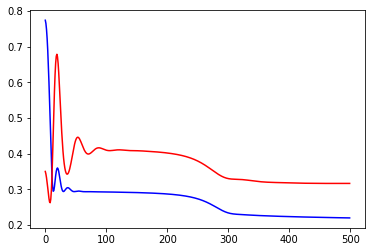

In [10]:
epoch = np.arange(0, epochs)
plt.plot(epoch,loss_train, color='b')
plt.plot(epoch,loss_vali, color='r')
plt.show()

D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


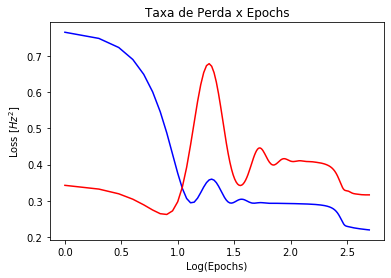

In [11]:
plt.figure()
plt.plot(np.log10(epoch),loss_train, color='b')
plt.plot(np.log10(epoch),loss_vali, color='r')
plt.title("Taxa de Perda x Epochs")
plt.xlabel("Log(Epochs)")
plt.ylabel("Loss [$Hz^2$]")
plt.show()

## REDE ORIGINAL

LR = 0.05
EPOCHS = 5000

Teste Loss: 0.0412
Teste Cosine Similarity: 0.8737

Teste Loss: 0.1962
Teste Cosine Similarity: 0.6633


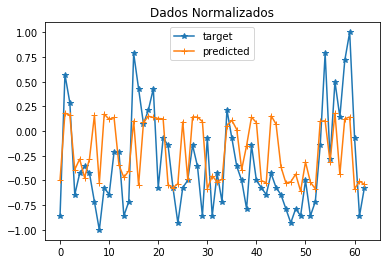

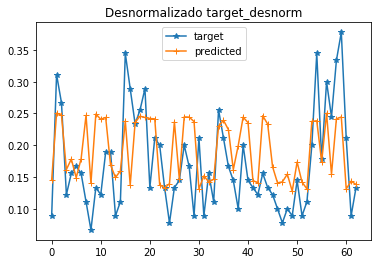

In [12]:
# Transformando o dado de teste
X_test_scaled = scaler_x.fit_transform(X_test)
y_test_scaled = scaler_y.fit_transform(y_test)

# Avaliando a acurácia do modelo utilizando os dados de teste transformados
inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
targets = torch.autograd.Variable(torch.Tensor(y_test_scaled.astype(np.float32)).float())

optimizer.zero_grad()
out = net(inputs)
loss = criterion(out, targets)
loss.backward()
optimizer.step()

predicted = out.data

print('Teste Loss: %.4f' % (loss.item()))

# Implementando a métrica do Cosine Similarity
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
cos_sim = cos(targets, predicted)
print('Teste Cosine Similarity: %.4f' % (cos_sim.item()))

ninput = np.arange(len(X_test))
plt.figure()
plt.plot(ninput, y_test_scaled, '-*', label = 'target')
plt.plot(ninput, predicted.numpy(), '-+', label = 'predicted')
plt.title('Dados Normalizados')
plt.legend()
plt.show()

# Fazendo a transformação inversa para desnormalizar o dado de teste
predicted_desnorm = scaler_y.inverse_transform(predicted.numpy())
target_desnorm = scaler_y.inverse_transform(y_test_scaled)

plt.figure()
plt.plot(ninput, target_desnorm, '-*', label = 'target')
plt.plot(ninput, predicted_desnorm, '-+', label = 'predicted')
plt.title('Desnormalizado target_desnorm')
plt.legend()
plt.show()

## Salvar o melhor modelo

#### https://discuss.pytorch.org/t/save-the-best-model/30430/2

model = nn.Linear(10, 2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

for epoch in range(10):
    optimizer.zero_grad()
    output = model(torch.randn(1, 10))
    loss = criterion(output, torch.randn(1, 2))
    loss.backward()
    optimizer.step()
    
    # Save 2nd epoch
    if epoch == 2:
        best_model = model  # Won't work!
        #best_model = copy.deepcopy(model)  # Will work
        
### Compare models
for param1, param2 in zip(best_model.parameters(), model.parameters()):
    print((param1 == param2).all())

#### https://github.com/pytorch/examples/blob/537f6971872b839b36983ff40dafe688276fe6c3/imagenet/main.py#L237

for epoch in range(args.start_epoch, args.epochs):
    if args.distributed:
        train_sampler.set_epoch(epoch)
    adjust_learning_rate(optimizer, epoch, args)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch, args)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion, args)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': args.arch,
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best)
    
    
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

## Plot do gráfico de training e validation loss simultâneo

#### https://discuss.pytorch.org/t/plotting-loss-curve/42632
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataLoader:
        images, labels = data

        outputs = model(images)
        loss = criterion_label(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0) 

    epoch_loss = running_loss / len(dataloaders['train'])
    losses.append(epoch_loss)

##### Plot your learning curves in real time in your web browser.
##### https://github.com/nalepae/pierogi/

##### Outras sugestões
##### https://discuss.pytorch.org/t/easiest-way-to-draw-training-validation-loss/13195/9